# LAB 5 : Convolutional Neural Networks  

Name : Hrishikesh Pable

Roll Number : 200010037

Referrence Material : 

  MNIST Digit Dataset : http://yann.lecun.com/exdb/mnist/

  CNN : https://towardsdatascience.com/a-guide-to-convolutional-neural-networks-from-scratch-f1e3bfc3e2de

#**Problem 1** : Demonstrate the working principle of convolution neural network (CNN)

Observation to be demonstrated:
1. Use suitable data to demonstrate the same (MNIST digit data can be used).
2. Demonstrate the translation invariant property of pooling layer (can choose two
image, from which one is translated and show the output of pooling layer is near
to identical for both the images ).
3. Demonstrate how backpropagation works with max pooling layer.

the same.

**Note: Take only two class and a small network, and write you own code to demonstrate the same.**

## Write down the Objectives, Hypothesis and Experimental description for the above problem


## Objectives

We want to perform classification of MNIST digit data using CNN. 

A CNN is a neural network that typically contains several types of layers, including convolutional layers, pooling layers, and fully connected layers.

The working principle of CNN is to extract features from the input image by performing convolution with a kernel. These features are then used to classify the image.

![Convolutional Neural Network](conv_net.webp)

## Programming : 
  Please write a program to demonstrate the same

In [57]:
## Write your code here

#Layers

import numpy as np


def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)


def cross_entropy(x):
    return -np.log(x)


def regularized_cross_entropy(layers, lam, x):
    loss = cross_entropy(x)
    for layer in layers:
        loss += lam * (np.linalg.norm(layer.get_weights()) ** 2)
    return loss


def leakyReLU(x, alpha=0.001):
    return x * alpha if x < 0 else x


def leakyReLU_derivative(x, alpha=0.01):
    return alpha if x < 0 else 1


def lr_schedule(learning_rate, iteration): # updated code , this will fix the error 
    if iteration == 0:
        return learning_rate
    if (iteration >= 0) and (iteration <= 10000):
        return learning_rate
    if iteration > 10000:
        return learning_rate * 0.1
    if iteration > 30000:
        return learning_rate * 0.1

class Convolutional:                                        # convolution layer using 3x3 filters

    def __init__(self, name, num_filters=16, stride=1, size=3, activation=None):
        self.name = name
        self.filters = np.random.randn(num_filters, size, size) * 0.1
        self.stride = stride
        self.size = size
        self.activation = activation
        self.last_input = None
        self.leakyReLU = np.vectorize(leakyReLU)
        self.leakyReLU_derivative = np.vectorize(leakyReLU_derivative)

    def forward(self, image):
        self.last_input = image                             # keep track of last input for later backward propagation

        input_dimension = image.shape[1]                                                # input dimension
        output_dimension = int((input_dimension - self.size) / self.stride) + 1         # output dimension

        out = np.zeros((self.filters.shape[0], output_dimension, output_dimension))     # create the matrix to hold the
                                                                                        # values of the convolution

        for f in range(self.filters.shape[0]):              # convolve each filter over the image,
            tmp_y = out_y = 0                               # moving it vertically first and then horizontally
            while tmp_y + self.size <= input_dimension:
                tmp_x = out_x = 0
                while tmp_x + self.size <= input_dimension:
                    patch = image[:, tmp_y:tmp_y + self.size, tmp_x:tmp_x + self.size]
                    out[f, out_y, out_x] += np.sum(self.filters[f] * patch)
                    tmp_x += self.stride
                    out_x += 1
                tmp_y += self.stride
                out_y += 1
        if self.activation == 'relu':                       # apply ReLU activation function
            self.leakyReLU(out)
            print("asdfasdfaisdfbasuidfyasudfgi")
            
        return out

    def backward(self, din, learn_rate=0.005):
        input_dimension = self.last_input.shape[1]          # input dimension

        if self.activation == 'relu':                       # back propagate through ReLU
           self.leakyReLU_derivative(din)

        dout = np.zeros(self.last_input.shape)              # loss gradient of the input to the convolution operation
        dfilt = np.zeros(self.filters.shape)                # loss gradient of filter

        for f in range(self.filters.shape[0]):              # loop through all filters
            tmp_y = out_y = 0
            while tmp_y + self.size <= input_dimension:
                tmp_x = out_x = 0
                while tmp_x + self.size <= input_dimension:
                    patch = self.last_input[:, tmp_y:tmp_y + self.size, tmp_x:tmp_x + self.size]
                    dfilt[f] += np.sum(din[f, out_y, out_x] * patch, axis=0)
                    dout[:, tmp_y:tmp_y + self.size, tmp_x:tmp_x + self.size] += din[f, out_y, out_x] * self.filters[f]
                    tmp_x += self.stride
                    out_x += 1
                tmp_y += self.stride
                out_y += 1
        self.filters -= learn_rate * dfilt                  # update filters using SGD
        return dout                                         # return the loss gradient for this layer's inputs

    def get_weights(self):
        return np.reshape(self.filters, -1)


class Pooling:                                              # max pooling layer using pool size equal to 2
    def __init__(self, name, stride=2, size=2):
        self.name = name
        self.last_input = None
        self.stride = stride
        self.size = size

    def forward(self, image):
        self.last_input = image                             # keep track of last input for later backward propagation

        num_channels, h_prev, w_prev = image.shape
        h = int((h_prev - self.size) / self.stride) + 1     # compute output dimensions after the max pooling
        w = int((w_prev - self.size) / self.stride) + 1

        downsampled = np.zeros((num_channels, h, w))        # hold the values of the max pooling

        for i in range(num_channels):                       # slide the window over every part of the image and
            curr_y = out_y = 0                              # take the maximum value at each step
            while curr_y + self.size <= h_prev:             # slide the max pooling window vertically across the image
                curr_x = out_x = 0
                while curr_x + self.size <= w_prev:         # slide the max pooling window horizontally across the image
                    patch = image[i, curr_y:curr_y + self.size, curr_x:curr_x + self.size]
                    downsampled[i, out_y, out_x] = np.max(patch)       # choose the maximum value within the window
                    curr_x += self.stride                              # at each step and store it to the output matrix
                    out_x += 1
                curr_y += self.stride
                out_y += 1

        return downsampled

    def backward(self, din, learning_rate):
        num_channels, orig_dim, *_ = self.last_input.shape      # gradients are passed through the indices of greatest
                                                                # value in the original pooling during the forward step

        dout = np.zeros(self.last_input.shape)                  # initialize derivative

        for c in range(num_channels):
            tmp_y = out_y = 0
            while tmp_y + self.size <= orig_dim:
                tmp_x = out_x = 0
                while tmp_x + self.size <= orig_dim:
                    patch = self.last_input[c, tmp_y:tmp_y + self.size, tmp_x:tmp_x + self.size]    # obtain index of largest
                    (x, y) = np.unravel_index(np.nanargmax(patch), patch.shape)                     # value in patch
                    dout[c, tmp_y + x, tmp_x + y] += din[c, out_y, out_x]
                    tmp_x += self.stride
                    out_x += 1
                tmp_y += self.stride
                out_y += 1

        return dout

    def get_weights(self):                          # pooling layers have no weights
        return 0


class FullyConnected:                               # fully-connected layer
    def __init__(self, name, nodes1, nodes2, activation):
        self.name = name
        self.weights = np.random.randn(nodes1, nodes2) * 0.1
        self.biases = np.zeros(nodes2)
        self.activation = activation
        self.last_input_shape = None
        self.last_input = None
        self.last_output = None
        self.leakyReLU = np.vectorize(leakyReLU)
        self.leakyReLU_derivative = np.vectorize(leakyReLU_derivative)

    def forward(self, input):
        self.last_input_shape = input.shape         # keep track of last input shape before flattening
                                                    # for later backward propagation

        input = input.flatten()                                 # flatten input

        output = np.dot(input, self.weights) + self.biases      # forward propagate

        if self.activation == 'relu':                           # apply ReLU activation function
            self.leakyReLU(output)

        self.last_input = input                     # keep track of last input and output for later backward propagation
        self.last_output = output

        return output

    def backward(self, din, learning_rate=0.005):
        if self.activation == 'relu':                             # back propagate through ReLU
           self.leakyReLU_derivative(din)

        self.last_input = np.expand_dims(self.last_input, axis=1)
        din = np.expand_dims(din, axis=1)

        dw = np.dot(self.last_input, np.transpose(din))           # loss gradient of final dense layer weights
        db = np.sum(din, axis=1).reshape(self.biases.shape)       # loss gradient of final dense layer biases

        self.weights -= learning_rate * dw                        # update weights and biases
        self.biases -= learning_rate * db

        dout = np.dot(self.weights, din)
        return dout.reshape(self.last_input_shape)

    def get_weights(self):
        return np.reshape(self.weights, -1)


class Dense:                                        # dense layer with softmax activation
    def __init__(self, name, nodes, num_classes):
        self.name = name
        self.weights = np.random.randn(nodes, num_classes) * 0.1
        self.biases = np.zeros(num_classes)
        self.last_input_shape = None
        self.last_input = None
        self.last_output = None

    def forward(self, input):
        self.last_input_shape = input.shape         # keep track of last input shape before flattening
                                                    # for later backward propagation

        input = input.flatten()                                 # flatten input

        output = np.dot(input, self.weights) + self.biases      # forward propagate

        self.last_input = input                     # keep track of last input and output for later backward propagation
        self.last_output = output

        return softmax(output)

    def backward(self, din, learning_rate=0.005):
        for i, gradient in enumerate(din):
            if gradient == 0:                   # the derivative of the loss with respect to the output is nonzero
                continue                        # only for the correct class, so skip if the gradient is zero

            t_exp = np.exp(self.last_output)                      # gradient of dout[i] with respect to output
            dout_dt = -t_exp[i] * t_exp / (np.sum(t_exp) ** 2)
            dout_dt[i] = t_exp[i] * (np.sum(t_exp) - t_exp[i]) / (np.sum(t_exp) ** 2)

            dt = gradient * dout_dt                               # gradient of loss with respect to output

            dout = self.weights @ dt                              # gradient of loss with respect to input

            # update weights and biases
            self.weights -= learning_rate * (np.transpose(self.last_input[np.newaxis]) @ dt[np.newaxis])
            self.biases -= learning_rate * dt

            return dout.reshape(self.last_input_shape)            # return the loss gradient for this layer's inputs

    def get_weights(self):
        return np.reshape(self.weights, -1)

In [39]:
# Load mnist dataset

from keras.datasets import mnist
import idx2numpy


def load_mnist_dataset():
    X_train = idx2numpy.convert_from_file('MNIST_data/train-images.idx3-ubyte')
    train_labels = idx2numpy.convert_from_file('MNIST_data/train-labels.idx1-ubyte')
    X_test = idx2numpy.convert_from_file('MNIST_data/t10k-images.idx3-ubyte')
    test_labels = idx2numpy.convert_from_file('MNIST_data/t10k-labels.idx1-ubyte')

    train_images = []                                                   # reshape train images so that the training set
    for i in range(X_train.shape[0]):                                   # is of shape (60000, 1, 28, 28)
        train_images.append(np.expand_dims(X_train[i], axis=0))
    train_images = np.array(train_images)

    test_images = []                                                    # reshape test images so that the test set
    for i in range(X_test.shape[0]):                                    # is of shape (10000, 1, 28, 28)
        test_images.append(np.expand_dims(X_test[i], axis=0))
    test_images = np.array(test_images)


    train_filter = np.where((train_labels == 0) | (train_labels == 1))
    test_filter = np.where((test_labels == 0) | (test_labels == 1))
    
    train_images, train_labels = train_images[train_filter], train_labels[train_filter]
    test_images, test_labels = test_images[test_filter], test_labels[test_filter]
    
    #Create Validation set using 80-20 split; First permute the data
    perm = np.random.permutation(train_images.shape[0])
    train_images = train_images[perm]
    train_labels = train_labels[perm]
    
    split_size = int(0.8 * train_images.shape[0])
    validation_images = train_images[split_size:]
    validation_labels = train_labels[split_size:]
    train_images = train_images[:split_size]
    train_labels = train_labels[:split_size]
    
    
    train_images = train_images / 255                                    # normalize the data
    validation_images = validation_images / 255
    test_images = test_images / 255
    
    print("Number of training images: " + str(train_images.shape[0]))
    print("Number of validation images: " + str(validation_images.shape[0]))
    print("Number of test images: " + str(test_images.shape[0]))
    

    return {
        'train_images': train_images,
        'train_labels': train_labels,
        'validation_images': validation_images,
        'validation_labels': validation_labels,
        'test_images': test_images,
        'test_labels': test_labels
    }


    
# load_mnist_dataset()

In [40]:
# inout

import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import cv2
sns.set(color_codes=True)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)          # suppress messages from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


def plot_accuracy_curve(accuracy_history, val_accuracy_history):
    plt.plot(accuracy_history, 'b', linewidth=3.0, label='Training accuracy')
    plt.plot(val_accuracy_history, 'r', linewidth=3.0, label='Validation accuracy')
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel('Accuracy rate', fontsize=16)
    plt.legend()
    plt.title('Training Accuracy', fontsize=16)
    plt.savefig('training_accuracy.png')
    plt.show()


def plot_learning_curve(loss_history):
    plt.plot(loss_history, 'b', linewidth=3.0, label='Cross entropy')
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend()
    plt.title('Learning Curve', fontsize=16)
    plt.savefig('learning_curve.png')
    plt.show()


def plot_sample(image, true_label, predicted_label):
    plt.imshow(image)
    if true_label and predicted_label is not None:
        if type(true_label) == 'int':
            plt.title('True label: %d, Predicted Label: %d' % (true_label, predicted_label))
        else:
            plt.title('True label: %s, Predicted Label: %s' % (true_label, predicted_label))
    plt.show()


def plot_histogram(layer_name, layer_weights):
    plt.hist(layer_weights)
    plt.title('Histogram of ' + str(layer_name))
    plt.xlabel('Value')
    plt.ylabel('Number')
    plt.show()


def to_gray(image_name):
    image = cv2.imread(image_name + '.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2.imshow('Gray image', image)
    cv2.imwrite(image_name + '.png', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()



In [41]:
import numpy as np
import time


class Network:
    def __init__(self):
        self.layers = []

    def add_layer(self, layer):
        self.layers.append(layer)

    def build_model(self, type):
        
        if(type=='simple_dense'):
            self.add_layer(Dense(name='dense', nodes=28 * 28, num_classes=2))
            
            
        elif(type=='simple_conv'):
            self.add_layer(Convolutional(name='conv1', num_filters=8, stride=2, size=3, activation='relu'))
            self.add_layer(Pooling(name='pool1', stride=2, size=2))
            self.add_layer(Dense(name='dense', nodes=8 * 6 * 6, num_classes=2))
            
            
        elif(type=='complex_conv'):
            
            self.add_layer(Convolutional(name='conv1', num_filters=16, stride=1, size=3, activation='relu'))
            self.add_layer(Pooling(name='pool1', stride=2, size=2))
            self.add_layer(Convolutional(name='conv2', num_filters=32, stride=1, size=3, activation='relu'))
            self.add_layer(Pooling(name='pool2', stride=2, size=2))
            self.add_layer(Dense(name='dense', nodes=32 * 5 * 5, num_classes=2))
            
        

    def forward(self, image, plot_feature_maps):                # forward propagate
        for layer in self.layers:
            if plot_feature_maps:
                image = (image * 255)[0, :, :]
                plot_sample(image, None, None)
            image = layer.forward(image)
        return image

    def backward(self, gradient, learning_rate):                # backward propagate
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient, learning_rate)

    def train(self, dataset, num_epochs, learning_rate, validate, regularization, print_weights, verbose):
        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
        for epoch in range(1, num_epochs + 1):
            print('\n--- Epoch {0} ---'.format(epoch))
            loss, tmp_loss, num_corr = 0, 0, 0
            initial_time = time.time()
            for i in range(400): ## len(dataset['train_images']) --> 400
                if i % 100 == 99:
                    accuracy = (num_corr / (i + 1)) * 100       # compute training accuracy and loss up to iteration i
                    loss = tmp_loss / (i + 1)

                    history['loss'].append(loss)                # update history
                    history['accuracy'].append(accuracy)

                    if validate:
                        indices = np.random.permutation(dataset['validation_images'].shape[0])
                        val_loss, val_accuracy = self.evaluate(
                            dataset['validation_images'][indices, :],
                            dataset['validation_labels'][indices],
                            regularization,
                            plot_correct=0,
                            plot_missclassified=0,
                            plot_feature_maps=0,
                            verbose=0
                        )
                        history['val_loss'].append(val_loss)
                        history['val_accuracy'].append(val_accuracy)

                        if verbose:
                            print('[Step %05d]: Loss %02.3f | Accuracy: %02.3f | Time: %02.2f seconds | '
                                  'Validation Loss %02.3f | Validation Accuracy: %02.3f' %
                                  (i + 1, loss, accuracy, time.time() - initial_time, val_loss, val_accuracy))
                    elif verbose:
                        print('[Step %05d]: Loss %02.3f | Accuracy: %02.3f | Time: %02.2f seconds' %
                              (i + 1, loss, accuracy, time.time() - initial_time))

                    # restart time
                    initial_time = time.time()

                image = dataset['train_images'][i]
                label = dataset['train_labels'][i]

                tmp_output = self.forward(image, plot_feature_maps=0)       # forward propagation

                # compute (regularized) cross-entropy and update loss
                tmp_loss += regularized_cross_entropy(self.layers, regularization, tmp_output[label])

                if np.argmax(tmp_output) == label:                          # update accuracy
                    num_corr += 1

                gradient = np.zeros(10)                                     # compute initial gradient
                gradient[label] = -1 / tmp_output[label] + np.sum(
                    [2 * regularization * np.sum(np.absolute(layer.get_weights())) for layer in self.layers])

                learning_rate = lr_schedule(learning_rate, iteration=i)     # learning rate decay

                self.backward(gradient, learning_rate)                      # backward propagation

        if verbose:
            print('Train Loss: %02.3f' % (history['loss'][-1]))
            print('Train Accuracy: %02.3f' % (history['accuracy'][-1]))
            plot_learning_curve(history['loss'])
            plot_accuracy_curve(history['accuracy'], history['val_accuracy'])

        if print_weights:
            for layer in self.layers:
                if hasattr(layer, 'weights'):
                    print(layer.name + ' weights:')

    def evaluate(self, X, y, regularization, plot_correct, plot_missclassified, plot_feature_maps, verbose):
        loss, num_correct = 0, 0
        for i in range(len(X)):
            tmp_output = self.forward(X[i], plot_feature_maps)              # forward propagation

            # compute cross-entropy update loss
            loss += regularized_cross_entropy(self.layers, regularization, tmp_output[y[i]])

            prediction = np.argmax(tmp_output)                              # update accuracy
            if prediction == y[i]:
                num_correct += 1
                if plot_correct:                                            # plot correctly classified digit
                    image = (X[i] * 255)[0, :, :]
                    plot_sample(image, y[i], prediction)
                    plot_correct = 1
            else:
                if plot_missclassified:                                     # plot missclassified digit
                    image = (X[i] * 255)[0, :, :]
                    plot_sample(image, y[i], prediction)
                    plot_missclassified = 1

        test_size = len(X)
        accuracy = (num_correct / test_size) * 100
        loss = loss / test_size
        if verbose:
            print('Test Loss: %02.3f' % loss)
            print('Test Accuracy: %02.3f' % accuracy)
        return loss, accuracy


--- Loading mnist dataset ---
Number of training images: 10132
Number of validation images: 2533
Number of test images: 2115

--- Building simple dense network ---

--- Training the model ---

--- Epoch 1 ---
[Step 00100]: Loss 0.172 | Accuracy: 93.000 | Time: 0.07 seconds | Validation Loss 0.062 | Validation Accuracy: 99.487
[Step 00200]: Loss 0.112 | Accuracy: 96.500 | Time: 0.07 seconds | Validation Loss 0.037 | Validation Accuracy: 99.566
[Step 00300]: Loss 0.086 | Accuracy: 97.333 | Time: 0.06 seconds | Validation Loss 0.029 | Validation Accuracy: 99.645
[Step 00400]: Loss 0.069 | Accuracy: 98.000 | Time: 0.09 seconds | Validation Loss 0.024 | Validation Accuracy: 99.684
Train Loss: 0.069
Train Accuracy: 98.000


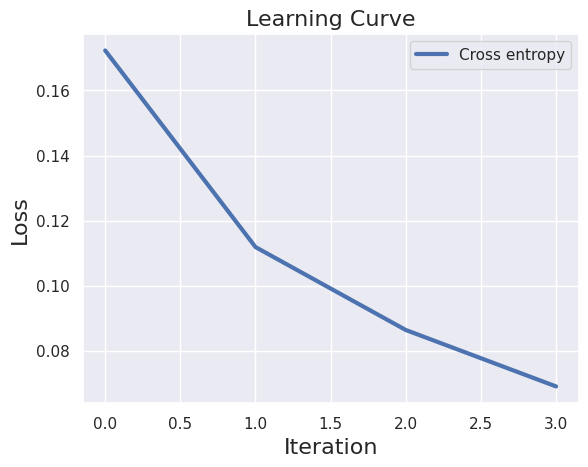

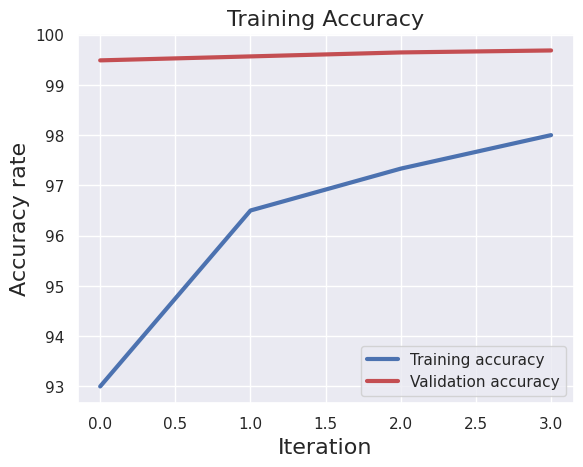


--- Testing the model ---
Test Loss: 0.019
Test Accuracy: 99.905

--- Building simple convolutional network ---

--- Training the model ---

--- Epoch 1 ---
[Step 00100]: Loss 0.521 | Accuracy: 78.000 | Time: 23.63 seconds | Validation Loss 0.258 | Validation Accuracy: 98.658
[Step 00200]: Loss 0.341 | Accuracy: 88.500 | Time: 21.99 seconds | Validation Loss 0.090 | Validation Accuracy: 98.776
[Step 00300]: Loss 0.247 | Accuracy: 92.333 | Time: 21.90 seconds | Validation Loss 0.056 | Validation Accuracy: 99.092
[Step 00400]: Loss 0.194 | Accuracy: 94.250 | Time: 21.67 seconds | Validation Loss 0.040 | Validation Accuracy: 99.171
Train Loss: 0.194
Train Accuracy: 94.250


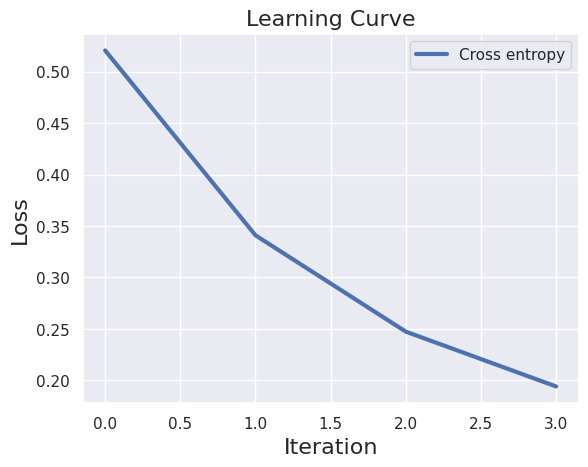

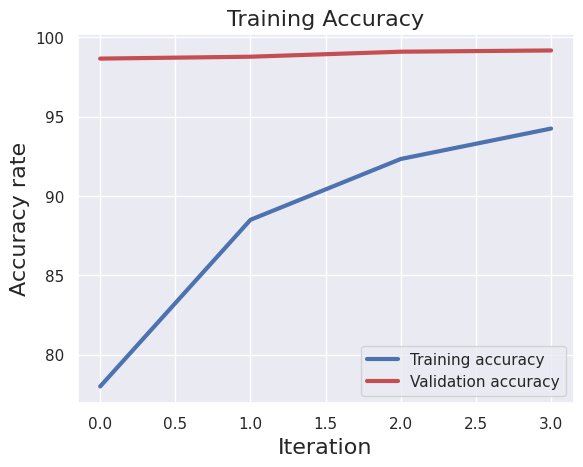


--- Testing the model ---
Test Loss: 0.033
Test Accuracy: 99.622

--- Building complex convolutional network ---

--- Training the model ---

--- Epoch 1 ---
[Step 00100]: Loss 0.114 | Accuracy: 95.000 | Time: 297.66 seconds | Validation Loss 0.030 | Validation Accuracy: 99.092
[Step 00200]: Loss 0.073 | Accuracy: 97.000 | Time: 325.30 seconds | Validation Loss 0.018 | Validation Accuracy: 99.408
[Step 00300]: Loss 0.051 | Accuracy: 98.000 | Time: 332.63 seconds | Validation Loss 0.015 | Validation Accuracy: 99.526
[Step 00400]: Loss 0.042 | Accuracy: 98.250 | Time: 350.99 seconds | Validation Loss 0.012 | Validation Accuracy: 99.605
Train Loss: 0.042
Train Accuracy: 98.250


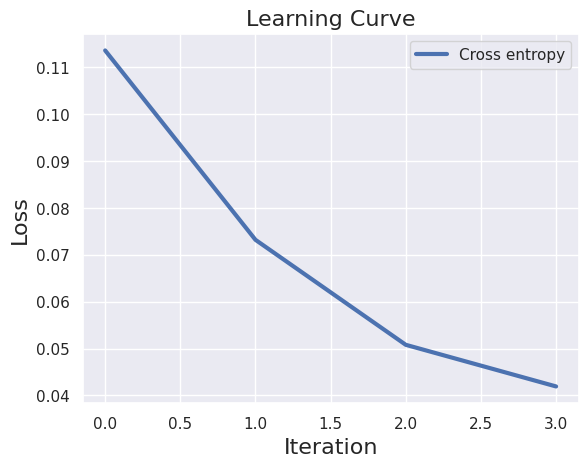

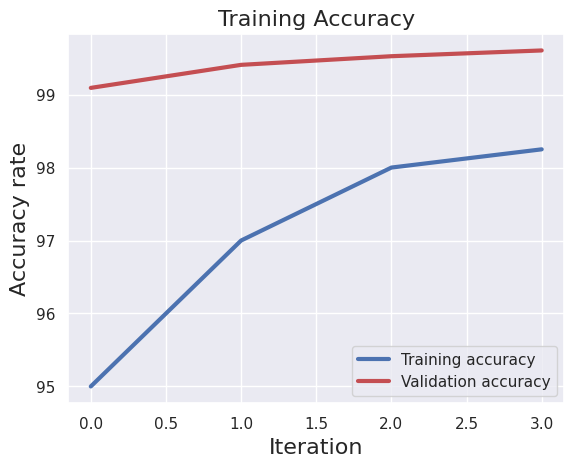


--- Testing the model ---
Test Loss: 0.005
Test Accuracy: 99.811


In [43]:
# Train and evaluate the model on MNIST and CIFAR-10 datasets
if __name__ == '__main__':

    '''
        Hyper parameters
        
            - dataset_name              choose between 'mnist' and 'cifar'
            - num_epochs                number of epochs
            - learning_rate             learning rate
            - validate                  0 -> no validation, 1 -> validation
            - regularization            regularization term (i.e., lambda)
            - verbose                   > 0 --> verbosity
    '''

    dataset_name = 'mnist'
    num_epochs = 1
    learning_rate = 0.01
    validate = 1
    regularization = 0
    verbose = 1
    plot_weights = 0
    plot_correct = 0
    plot_missclassified = 0
    plot_feature_maps = 0

    print('\n--- Loading ' + dataset_name + ' dataset ---')                 # load dataset
    dataset = load_mnist_dataset()


    # Simple dense network
    print('\n--- Building simple dense network ---')                       # build simple dense network
    simple_dense_model = Network()
    simple_dense_model.build_model('simple_dense')
    


    print('\n--- Training the model ---')                                   # train model
    simple_dense_model.train(
        dataset,
        num_epochs,
        learning_rate,
        validate,
        regularization,
        plot_weights,
        verbose
    )

    print('\n--- Testing the model ---')                                    # test model
    simple_dense_model.evaluate(
        dataset['test_images'],
        dataset['test_labels'],
        regularization,
        plot_correct,
        plot_missclassified,
        plot_feature_maps,
        verbose
    )

    # Simple convolutional network
    
    print('\n--- Building simple convolutional network ---')               # build simple convolutional network
    simple_conv_model = Network()
    simple_conv_model.build_model('simple_conv')
    
    print('\n--- Training the model ---')                                   # train model
    simple_conv_model.train(
        dataset,
        num_epochs,
        learning_rate,
        validate,
        regularization,
        plot_weights,
        verbose
    )

    print('\n--- Testing the model ---')                                    # test model
    simple_conv_model.evaluate(
        dataset['test_images'],
        dataset['test_labels'],
        regularization,
        plot_correct,
        plot_missclassified,
        plot_feature_maps,
        verbose
    )
    
    # Complex convolutional network
    print('\n--- Building complex convolutional network ---')              # build complex convolutional network
    complex_conv_model = Network()
    complex_conv_model.build_model('complex_conv')
    
    print('\n--- Training the model ---')                                   # train model
    complex_conv_model.train(
        dataset,
        num_epochs,
        learning_rate,
        validate,
        regularization,
        plot_weights,
        verbose
    )
    
    print('\n--- Testing the model ---')                                    # test model
    complex_conv_model.evaluate(
        dataset['test_images'],
        dataset['test_labels'],
        regularization,
        plot_correct,
        plot_missclassified,
        plot_feature_maps,
        verbose
    )
    


In [90]:
#Use 2 dummy images to show translational invariance in max pooling layer, by printing the output of the max pooling layer for the two images.


# Image 1
image1 = np.array( [[0, 0, 0, 0, 0, 0, 0, 0],
		            [0, 0, 0, 0, 0, 0, 0, 0],
		            [0, 0, 0, 0, 0, 0, 0, 0],
		            [0, 0, 0, 0, 0, 0, 0, 0],
		            [0, 0, 0, 0, 0, 0, 0, 0],
	      	        [0, 0, 1, 0, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0, 0, 0]]).reshape(1, 8, 8)

print('Image 1:')
print(image1)

# Image 2
image2 = np.array( [[0, 0, 0, 0, 0, 0, 0, 0],
		            [0, 0, 0, 0, 0, 0, 0, 0],
		            [0, 0, 0, 0, 0, 0, 0, 0],
		            [0, 0, 0, 0, 0, 0, 0, 0],
		            [0, 0, 0, 0, 0, 0, 0, 0],
	      	        [0, 0, 0, 1, 0, 0, 0, 0],
                    [0, 0, 0, 1, 0, 0, 0, 0],
                    [0, 0, 0, 1, 0, 0, 0, 0]]).reshape(1, 8, 8)


print('Image 2:')
print(image2)






Image 1:
[[[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]]]
Image 2:
[[[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0]
  [0 0 0 1 0 0 0 0]
  [0 0 0 1 0 0 0 0]]]


In [91]:
convolutional = Convolutional(name='conv1', num_filters=1, stride=1, size=3, activation=None)

output1 = convolutional.forward(image1)
print("Convolutional layer output for Image 1:")
print(output1)


output2 = convolutional.forward(image2)
print("Convolutional layer output for Image 2:")
print(output2)



Convolutional layer output for Image 1:
[[[ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.00586741 -0.21145635  0.25671757  0.          0.
    0.        ]
  [-0.02059255 -0.21736434  0.19538744  0.          0.
    0.        ]
  [-0.0132676  -0.32010826  0.23061421  0.          0.
    0.        ]]]
Convolutional layer output for Image 2:
[[[ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.00586741 -0.21145635  0.25671757  0.
    0.        ]
  [ 0.         -0.02059255 -0.21736434  0.19538744  0.
    0.        ]
  [ 0.         -0.0132676  -0.32010826  0.23061421  0.
    0.        ]]]


In [92]:

#MaxPool with size 2

pooling = Pooling(name='pool1', stride=2, size=2)

print('Max pooling layer output for Image 1:')
print(pooling.forward(output1))
print('\n')

print('Max pooling layer output for Image 2:')
print(pooling.forward(output2))
print('\n')

Max pooling layer output for Image 1:
[[[ 0.          0.          0.        ]
  [ 0.00586741  0.25671757  0.        ]
  [-0.0132676   0.23061421  0.        ]]]


Max pooling layer output for Image 2:
[[[0.         0.         0.        ]
  [0.00586741 0.25671757 0.        ]
  [0.         0.23061421 0.        ]]]




In [93]:
#MaxPool with size 3

pooling = Pooling(name='pool1', stride=2, size=3)

print('Max pooling layer output for Image 1:')
print(pooling.forward(output1))
print('\n')

print('Max pooling layer output for Image 2:')
print(pooling.forward(output2))
print('\n')

Max pooling layer output for Image 1:
[[[0.         0.        ]
  [0.25671757 0.25671757]]]


Max pooling layer output for Image 2:
[[[0.         0.        ]
  [0.00586741 0.25671757]]]




In [94]:
#MaxPool with size 3

pooling = Pooling(name='pool1', stride=2, size=4)

print('Max pooling layer output for Image 1:')
print(pooling.forward(output1))
print('\n')

print('Max pooling layer output for Image 2:')
print(pooling.forward(output2))
print('\n')

Max pooling layer output for Image 1:
[[[0.25671757 0.25671757]
  [0.25671757 0.25671757]]]


Max pooling layer output for Image 2:
[[[0.25671757 0.25671757]
  [0.25671757 0.25671757]]]




## Inferences and Conclusion : State all the key observations and conclusion

1. CNN model is able to classify the MNIST digit data with high accuracy.

2. Since the MNIST dataset is relatively simple, a dense layer performs better than CNN.

3. The pooling layer is shown to be translation invariant.

4. The size of the pooling layer should be large enough to exhibit translation invariance.

5. The greater the shift in the object, the larger the size of the pooling layer is needed to exhibit translation invariance.

6. Increase in convolutional layers drastically increases the training time.